In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import metpy.calc as mpcalc
import numpy as np
import xarray as xr

# load all nc files
#fdataDIR = 'CCS_country_daily_20030101-20191002/*.nc'

mfdataDIR = 'CDR_country_daily_19830101-20190630/*.nc'
ds = xr.open_mfdataset(mfdataDIR, combine='by_coords')
ds

<xarray.Dataset>
Dimensions:   (datetime: 13330, lat: 61, lon: 35)
Coordinates:
  * lat       (lat) float32 20.75 20.5 20.25 20.0 19.75 ... 6.5 6.25 6.0 5.75
  * lon       (lon) float32 97.25 97.5 97.75 98.0 ... 105.0 105.25 105.5 105.75
  * datetime  (datetime) datetime64[ns] 1983-01-01 1983-01-02 ... 2019-06-30
Data variables:
    crs       (datetime) int32 -2147483647 -2147483647 ... -2147483647
    precip    (datetime, lat, lon) float32 dask.array<chunksize=(365, 61, 35), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6

In [2]:
# # Create time slice from dates
# start_time = '2011-01-20'
# end_time = '2011-02-06'

# # Select NCEP/NCAR parameter and level
param = 'precip'
# level = 250

# # Remote get dataset using OPeNDAP method via xarray
# ds = xr.open_dataset('http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/'
#                      'ncep.reanalysis/pressure/{}.{}.nc'.format(param, start_time[:4]))

# Create slice variables subset domain
# time_slice = slice(start_time, end_time)
# lat_slice = slice(60, 40)
# lon_slice = slice(0, 360)

# # Get data, selecting time, level, lat/lon slice
# data = ds[param].sel(time=time_slice,
#                      level=level,
#                      lat=lat_slice,
#                      lon=lon_slice)
data = ds[param]

# Compute weights and take weighted average over latitude dimension
weights = np.cos(np.deg2rad(data.lat.values))
avg_data = (data * weights[None, :, None]).sum(dim='lat') / np.sum(weights)

# Get times and make array of datetime objects
vtimes = data.datetime.values.astype('datetime64[ms]').astype('O')

# Specify longitude values for chosen domain
lons = data.lon.values
# Specify latitude values for chosen domain
lats = data.lat.values

In [3]:
lons.min(), lons.max()

(97.25, 105.75)

In [4]:
lats.min(), lats.max()

(5.75, 20.75)

In [5]:
data

<xarray.DataArray 'precip' (datetime: 13330, lat: 61, lon: 35)>
dask.array<concatenate, shape=(13330, 61, 35), dtype=float32, chunksize=(366, 61, 35)>
Coordinates:
  * lat       (lat) float32 20.75 20.5 20.25 20.0 19.75 ... 6.5 6.25 6.0 5.75
  * lon       (lon) float32 97.25 97.5 97.75 98.0 ... 105.0 105.25 105.5 105.75
  * datetime  (datetime) datetime64[ns] 1983-01-01 1983-01-02 ... 2019-06-30
Attributes:
    grid_mapping:  crs

In [6]:
ds.precip[:,:,0]

<xarray.DataArray 'precip' (datetime: 13330, lat: 61)>
dask.array<getitem, shape=(13330, 61), dtype=float32, chunksize=(366, 61)>
Coordinates:
  * lat       (lat) float32 20.75 20.5 20.25 20.0 19.75 ... 6.5 6.25 6.0 5.75
    lon       float32 97.25
  * datetime  (datetime) datetime64[ns] 1983-01-01 1983-01-02 ... 2019-06-30
Attributes:
    grid_mapping:  crs

In [7]:
ds.precip[:,30,17]

<xarray.DataArray 'precip' (datetime: 13330)>
dask.array<getitem, shape=(13330,), dtype=float32, chunksize=(366,)>
Coordinates:
    lat       float32 13.25
    lon       float32 101.5
  * datetime  (datetime) datetime64[ns] 1983-01-01 1983-01-02 ... 2019-06-30
Attributes:
    grid_mapping:  crs

In [9]:
lat_lon = (13.73826, 100.532413)  # chula  13.73826, 100.532413
#lat_lon = (12.9864, 101.5021) # Wang Chan District, Rayong

# find index from value in array https://stackoverflow.com/questions/2566412/find-nearest-value-in-numpy-array
def find_nearest_index(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx #array[idx]

#convert specified lat lon to index in data
lat_index = find_nearest_index(ds.lat, lat_lon[0])
lon_index = find_nearest_index(ds.lon, lat_lon[1])

lat_index, lon_index

(28, 13)

In [10]:
ds_temp = ds.precip[:,lat_index,lon_index]
ds_temp = ds_temp.where(ds_temp != -99.).where(ds_temp != 0)
lat = ds_temp.lat.values
lon = ds_temp.lon.values
df = ds_temp.to_dataframe().drop(columns=['lat','lon'])
df['dayofyear'] = df.index.dayofyear
df['year'] = df.index.year
df.head()

,precip,dayofyear,year
datetime,,,
1983-01-01,NaN,1,1983
1983-01-02,NaN,2,1983
1983-01-03,NaN,3,1983
1983-01-04,NaN,4,1983
1983-01-05,NaN,5,1983


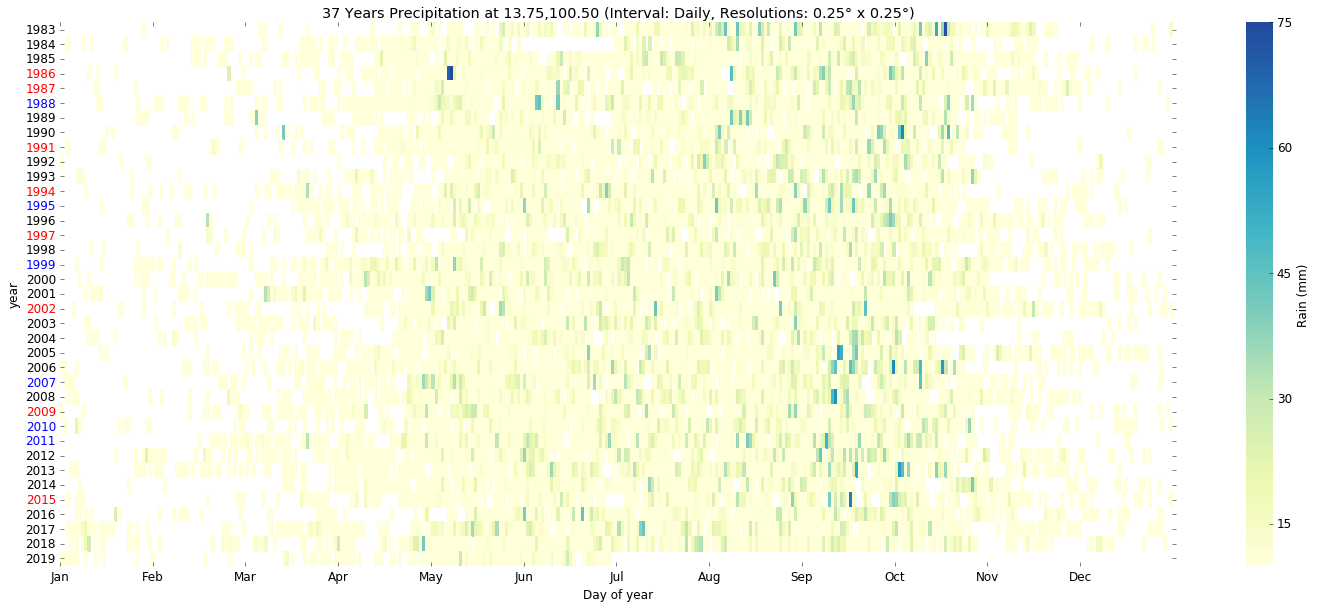

In [11]:
import numpy as np 
from pandas import DataFrame
import seaborn as sns
from matplotlib.dates import DateFormatter
%matplotlib inline

fig = plt.figure(figsize=(25, 10))
plt.style.use(['classic']) #  grey_background
#sns.set_style("darkgrid", {"axes.facecolor": ".9"})
rain = df.pivot("year","dayofyear", "precip")

#ax = sns.heatmap(rain, cmap="YlGnBu", center=30, vmin=0, vmax=75, cbar_kws={'label': 'Rain (mm)'})
ax = sns.heatmap(rain, cmap="YlGnBu", center=50, vmin=10, vmax=75, cbar_kws={'label': 'Rain (mm)'})

plt.xticks(np.linspace(0,365,13)[:-1], ('Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Nov', 'Dec'), rotation=0) 
#plt.xlabel("Month")
plt.xlabel("Day of year")
2
plt.title(f'37 Years Precipitation at {lat:.2f},{lon:.2f} (Interval: Daily, Resolutions: 0.25° x 0.25°)')
plt.gca().get_yticklabels()[5].set_color("blue") # La Nina
plt.gca().get_yticklabels()[12].set_color("blue")
plt.gca().get_yticklabels()[16].set_color("blue")
plt.gca().get_yticklabels()[24].set_color("blue")
plt.gca().get_yticklabels()[27].set_color("blue")
plt.gca().get_yticklabels()[28].set_color("blue")
plt.gca().get_yticklabels()[3].set_color("red") # El Nino
plt.gca().get_yticklabels()[4].set_color("red")
plt.gca().get_yticklabels()[8].set_color("red")
plt.gca().get_yticklabels()[11].set_color("red")
plt.gca().get_yticklabels()[14].set_color("red")
plt.gca().get_yticklabels()[19].set_color("red")
plt.gca().get_yticklabels()[26].set_color("red")
plt.gca().get_yticklabels()[32].set_color("red")

#fig.savefig(f'../37years_precip_{lat:.2f},{lon:.2f}.png', dpi=300, bbox_inches='tight', pad_inches=0.1)